In [8]:
from uncertainties import ufloat
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt
from scipy.odr import ODR,Model,RealData
import sys
from sympy import Symbol,symbols, diff
import sympy as sp

In [9]:
#paar Unsicherheitsfunktionen
def rechteck(x): #Unsicherheit bei Rechtecksverteilung oder bei zwei Dreiecksverteilungen
    return x/(2*np.sqrt(3))

def dreieck(x): #Unsicherheit bei Dreiecksverteilung
    return x/(2*np.sqrt(6))

def u_messgeraet(x,u_mess_rel,offset_u_mess,u_ablese): #Kombination aus Unsicherheit des Messgerätes und Ableseunsicherheit
    u_mess=(x+offset_u_mess)*u_mess_rel
    return np.sqrt(u_mess**2+u_ablese**2)

def u_kombiniert(unsicherheiten):
   return np.sqrt(np.sum(np.array(unsicherheiten)**2))

def rel_abweichung(messwert,theoriewert):
  return (messwert-theoriewert)/theoriewert

def rel_unsicherheit(x : ufloat) -> float:
  return x.s/x.n

def mittelwert(uarray :unp.uarray) -> ufloat:
  t_factor=np.array([1.84,1.32,1.2,1.14,1.11,1.09,1.08,1.07,1.06,1.05])
  length=uarray.size
  mean=uarray.mean()
  if length==1:
     return uarray[0]
  if (length<=11):
    mean=ufloat(mean.n,mean.s*t_factor[length-2])
  return mean

def uprint(ufloat : ufloat) -> None:
  print('{:.2uS}'.format(ufloat))




#prints "VARIABLE_NAME:  \SI{unit_factor* VARIABLE}{UNIT}"
#experimentell: gibt nicht den namen der eingegebenen variable zurück, 
# sondern den variablennamen der als erstes in der globalen Umgebung dem Objekt zugeteilt wurde

#unit should be given with \, so that latex can read it
# unit factor needs to be given if unit is not SI unit
def uprint_name(ufloat : ufloat,unit : str="",unit_factor : float=1) -> None:
   name = [k for k, v in globals().items() if v is ufloat][0]
   ufloat*=unit_factor
   print(name,":   \SI{", '{:.2uS}'.format(ufloat),"}{",unit,"}")

def uarray_print_name(uarray : unp.uarray) -> None:
   name = [k for k, v in globals().items() if v is uarray][0]
   print(name, ":")
   uarray_print(uarray)

def uarray_print(uarray : unp.uarray, row_length=5) -> None:
  for i in range(len(uarray)//5+1):
    for j in range(i*row_length,np.min(np.array([(i+1)*row_length,len(uarray)]))):
       print('{:.2uS}'.format(uarray[j]), end = "     ")
    print()

# 2. Strahldivergenz und Position des virtuellen Quellflecks des Senders bestimmen
## Strahlenprofil in vier Entfernungen messen
Messwerte

In [10]:
u_ablese_laenge = dreieck(2e-3) #standard ableseunsicherheit für längen, ist in einzelnen Fällen anders
print(u_ablese_laenge)
fussbreite_sender = ufloat(0.027,unp.sqrt(2)*u_ablese_laenge)
fussbreite_empfaenger = ufloat(0.035,unp.sqrt(2)*u_ablese_laenge)

abstand = unp.uarray(nominal_values=[0.7,0.8,0.9,1],
                     std_devs=u_kombiniert([u_ablese_laenge,dreieck(4e-3)])) + fussbreite_sender/2+fussbreite_empfaenger/2
uarray_print_name(abstand)
#Unsicherheits der Peakintensität fließt nicht mit ein
standardabweichung = unp.uarray(nominal_values=[0.082,0.092,0.114,0.139],
                             std_devs=np.sqrt(2)*u_ablese_laenge)

0.0004082482904638631
abstand :
0.7310(10)     0.8310(10)     0.9310(10)     1.0310(10)     


Quellfleck und Strahldivergenz bestimmen, plotten

In [11]:
def gerade(beta,x):
    #beta[0]: Steigung, beta[1]:y-Achsenabschnitt
    return beta[0]*x + beta[1]

model_gerade = Model(gerade)

In [12]:
#ODR-Fit quellfleck
data_quellfleck=RealData(unp.nominal_values(abstand),
                  unp.nominal_values(standardabweichung),
                  sx=unp.std_devs(abstand),
                  sy=unp.std_devs(standardabweichung))
odr_quellfleck= ODR(data_quellfleck, model_gerade,[ 0.19362993, -0.06383797])
odr_quellfleck.set_job(fit_type=0)
output_quellfleck=odr_quellfleck.run()
output_quellfleck.pprint()
beta_quellfleck = output_quellfleck.beta
beta_quellfleck_err=output_quellfleck.sd_beta

m_quellfleck = ufloat(beta_quellfleck[0],beta_quellfleck_err[0])
b_quellfleck = ufloat(beta_quellfleck[1],beta_quellfleck_err[1])

uprint_name(m_quellfleck)
uprint_name(b_quellfleck,unit="\cm",unit_factor=100)

Beta: [ 0.19362991 -0.06383795]
Beta Std Error: [0.02456411 0.02181449]
Beta Covariance: [[ 7.41894155e-06 -6.53608790e-06]
 [-6.53608790e-06  5.85100028e-06]]
Residual Variance: 81.3317561363224
Inverse Condition #: 0.06273874472423759
Reason(s) for Halting:
  Sum of squares convergence
m_quellfleck :   \SI{ 0.194(25) }{  }
b_quellfleck :   \SI{ -6.4(2.2) }{ \cm }


In [13]:
def nullstelle_gerade(beta):
    return -beta[1]/beta[0]

position_quellfleck = nullstelle_gerade(unp.uarray(beta_quellfleck,beta_quellfleck_err))
uprint_name(position_quellfleck, unit = "\cm", unit_factor=100)
print(rel_unsicherheit(position_quellfleck))

position_quellfleck :   \SI{ 33(12) }{ \cm }
0.3645051930345731


cursed

plot

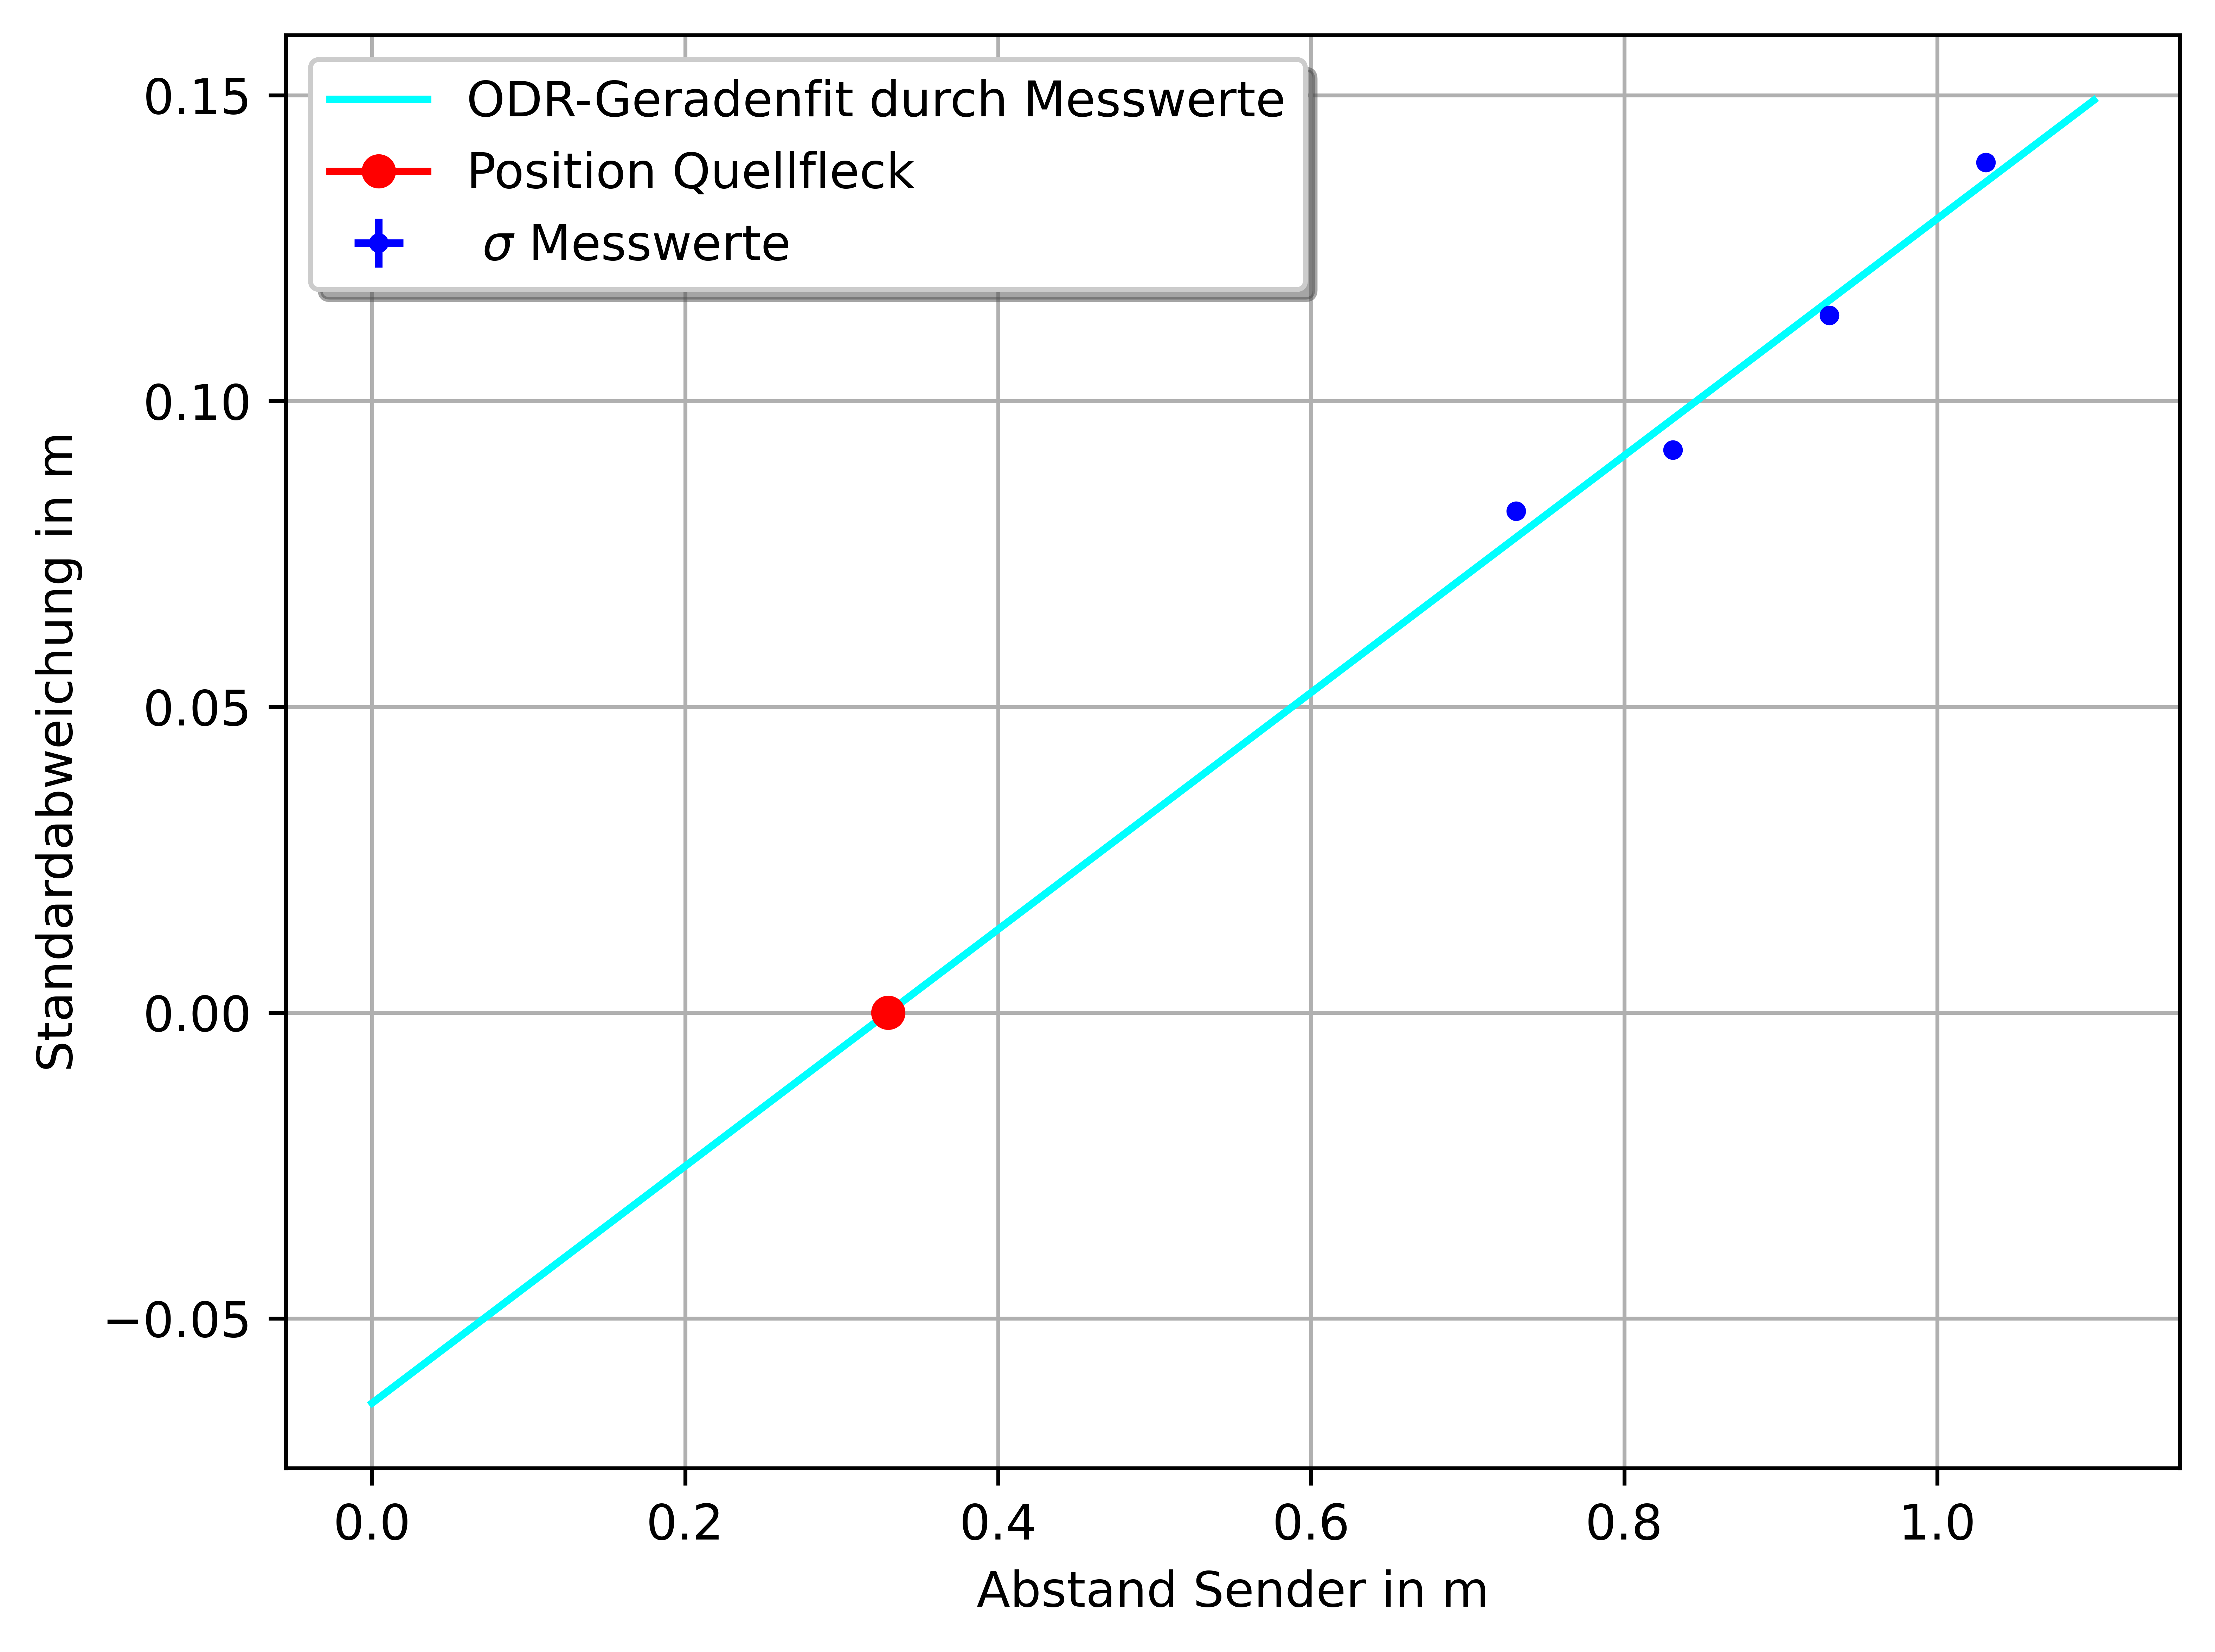

In [14]:
plt.figure(dpi=1000)
plt.errorbar(unp.nominal_values(abstand),unp.nominal_values(standardabweichung),
             xerr= unp.std_devs(abstand), yerr=unp.std_devs(standardabweichung),
             linestyle="", marker= ".",color = "blue", label = " $\sigma$ Messwerte")

x_int = np.linspace(0,1.1,1000)
plt.plot(x_int,gerade(beta_quellfleck,x_int), color = "cyan",
         label="ODR-Geradenfit durch Messwerte")
plt.plot(position_quellfleck.n,0,marker="o",color="red",label ="Position Quellfleck")

plt.grid()
plt.xlabel("Abstand Sender in m") 
plt.ylabel("Standardabweichung in m")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig("plot_quellfleck_bestimmung.pdf")

Strahldivergenz

In [15]:
#def strahldivergenz (sigma, d):
#    return unp.arctan(sigma/d)

#sigma,d = symbols('sigma,d')
#print(diff(2*sp.atan(sigma/d),sigma))
#print(diff(2*sp.atan(sigma/d),d))
#print(diff(sp.atan(d),d))

In [16]:
#strahldivergenz_unkrg = unp.degrees(strahldivergenz(standardabweichung,abstand))
#uarray_print_name(strahldivergenz_unkrg)

#strahldivergenz_krg = unp.degrees(strahldivergenz(standardabweichung,abstand-position_quellfleck))
#uarray_print_name(strahldivergenz_krg)

#strahldivergenz_krg_avg = mittelwert(strahldivergenz_krg)
#uprint_name(strahldivergenz_krg_avg, unit = "\degrees")

strahldivergenz_aus_fit = unp.degrees(unp.arctan(m_quellfleck))
uprint_name(strahldivergenz_aus_fit, unit = "\degrees")

strahldivergenz_aus_fit :   \SI{ 11.0(1.4) }{ \degrees }


plot

In [17]:
def konstante(beta,x):
    #beta[0]: Konstante
    return beta[0]+ 0*x

In [18]:
#plt.figure(dpi=1000)
#plt.errorbar(unp.nominal_values(abstand),unp.nominal_values(strahldivergenz_unkrg),
#             xerr=unp.std_devs(abstand),yerr=unp.std_devs(strahldivergenz_unkrg),
#             linestyle="", marker=".", color = "green", label ="Strahldivergenz ohne Quellfleckkorrektur")

#plt.errorbar(unp.nominal_values(abstand),unp.nominal_values(strahldivergenz_krg),
#             xerr=unp.std_devs(abstand),yerr=unp.std_devs(strahldivergenz_krg),
#             linestyle="", marker=".", color = "red", label ="Strahldivergenz mit Quellfleckkorrektur")

#x_int = np.linspace(0.65,1.1,1000)
#plt.plot(x_int,konstante([strahldivergenz_krg_avg.n],x_int),color="orange",
#         label="durchschn. Strahldivergenz")

#plt.grid()
#plt.xlabel("Abstand Sender in m") 
#plt.ylabel("Strahldivergenz in Grad")
#plt.legend(fancybox=True,shadow=True)
#plt.tight_layout()
#plt.savefig("plot_strahldivergenz.pdf")

# 3. Wellenlänge einer stehenden Welle bestimmen

In [19]:
position_minima = unp.uarray(nominal_values=[0.303,0.318,0.336,0.351,0.366],
                             std_devs=u_ablese_laenge)

abstand_minima_liste = [position_minima[i+1]-position_minima[i] for i in range(4)]
abstand_minima = unp.uarray(unp.nominal_values(abstand_minima_liste),unp.std_devs(abstand_minima_liste))
uarray_print_name(abstand_minima)

abstand_minima :
0.01500(58)     0.01800(58)     0.01500(58)     0.01500(58)     


In [20]:
wellenlaenge = 2 * abstand_minima
uarray_print_name(wellenlaenge)
wellenlaenge_avg = mittelwert(wellenlaenge)
uprint_name(wellenlaenge_avg, unit = "\cm",unit_factor=100)

wellenlaenge :
0.0300(12)     0.0360(12)     0.0300(12)     0.0300(12)     
wellenlaenge_avg :   \SI{ 3.150(69) }{ \cm }


# 4. Brechungsindex von PVC für Mikrowellen bestimmen 
## durch Messung der Ausfallswinkel bei fünf verschiedenen Einfallswinkeln

In [21]:
u_ablese_winkel = dreieck(2)
einfallswinkel = unp.radians(unp.uarray([15,25,35,45,55,65],std_devs=u_ablese_winkel))
ausfallswinkel = unp.radians(unp.uarray([9,13,18,22,26,30],std_devs=u_ablese_winkel))


In [22]:
brechungsindex_pvc = unp.sin(einfallswinkel)/unp.sin(ausfallswinkel)
uarray_print_name(brechungsindex_pvc)

brechungsindex_pvc_avg = mittelwert(brechungsindex_pvc)
uprint_name(brechungsindex_pvc_avg)

brechungsindex_pvc :
1.654(86)     1.879(65)     1.856(45)     1.888(36)     1.869(29)     
1.813(23)     
brechungsindex_pvc_avg :   \SI{ 1.826(24) }{  }


# 6. Intensität der Evaneszenswelle bei Totalreflexion messen

In [23]:
winkel_messung_totalreflexion = unp.radians(ufloat(55,u_ablese_winkel))

breite_luecke = unp.uarray([1e-3,3e-3,6e-3,8e-3,11e-3,20e-3,29e-3,4e-3,5e-3],
                           std_devs = u_ablese_laenge)

intensitaet_evaneszenz_messwerte = np.array([14.49,11.24,4.5,2.2,0.6,0.25,0.04,10.3,6.3])
u_intensitaet_evaneszenz = u_messgeraet(intensitaet_evaneszenz_messwerte, u_mess_rel=0.005,
                                         offset_u_mess=[8e-2]*5+[8e-3]*2+[8e-2]*2,
                                         u_ablese=dreieck(np.array([0.6,0.6,0.6,0.4,0.2,0.04,0.02,0.6,0.2])))
intensitaet_evaneszenz = unp.uarray(intensitaet_evaneszenz_messwerte,
                         std_devs=u_intensitaet_evaneszenz) #Volt gemessen

fitten, plotten, etc

In [24]:
def exp_abfall(beta,x):
    #beta[0]: Skalierung, beta[1]: abfallgeschw., beta[2]: Offset
    return beta[0]*np.exp(-beta[1]*x)+beta[2]

model_exp_abfall = Model(exp_abfall)

In [25]:
#ODR-Fit evaneszenz
data_evaneszenz=RealData(unp.nominal_values(breite_luecke),
                  unp.nominal_values(intensitaet_evaneszenz),
                  sx=unp.std_devs(breite_luecke),
                  sy=unp.std_devs(intensitaet_evaneszenz))
odr_evaneszenz= ODR(data_evaneszenz, model_exp_abfall,[2.15033806e+01, 2.58034155e+02, 3.04839979e-02])
odr_evaneszenz.set_job(fit_type=0)
output_evaneszenz=odr_evaneszenz.run()
output_evaneszenz.pprint()
beta_evaneszenz = output_evaneszenz.beta
beta_evaneszenz_err=output_evaneszenz.sd_beta

Beta: [2.15033814e+01 2.58034164e+02 3.04839694e-02]
Beta Std Error: [5.15286241e+00 2.92510627e+01 1.89037840e-02]
Beta Covariance: [[1.91835660e+00 8.63635717e+00 2.28832912e-03]
 [8.63635717e+00 6.18180849e+01 2.14928369e-02]
 [2.28832912e-03 2.14928369e-02 2.58184249e-05]]
Residual Variance: 13.841009003734053
Inverse Condition #: 0.10084257426479994
Reason(s) for Halting:
  Sum of squares convergence


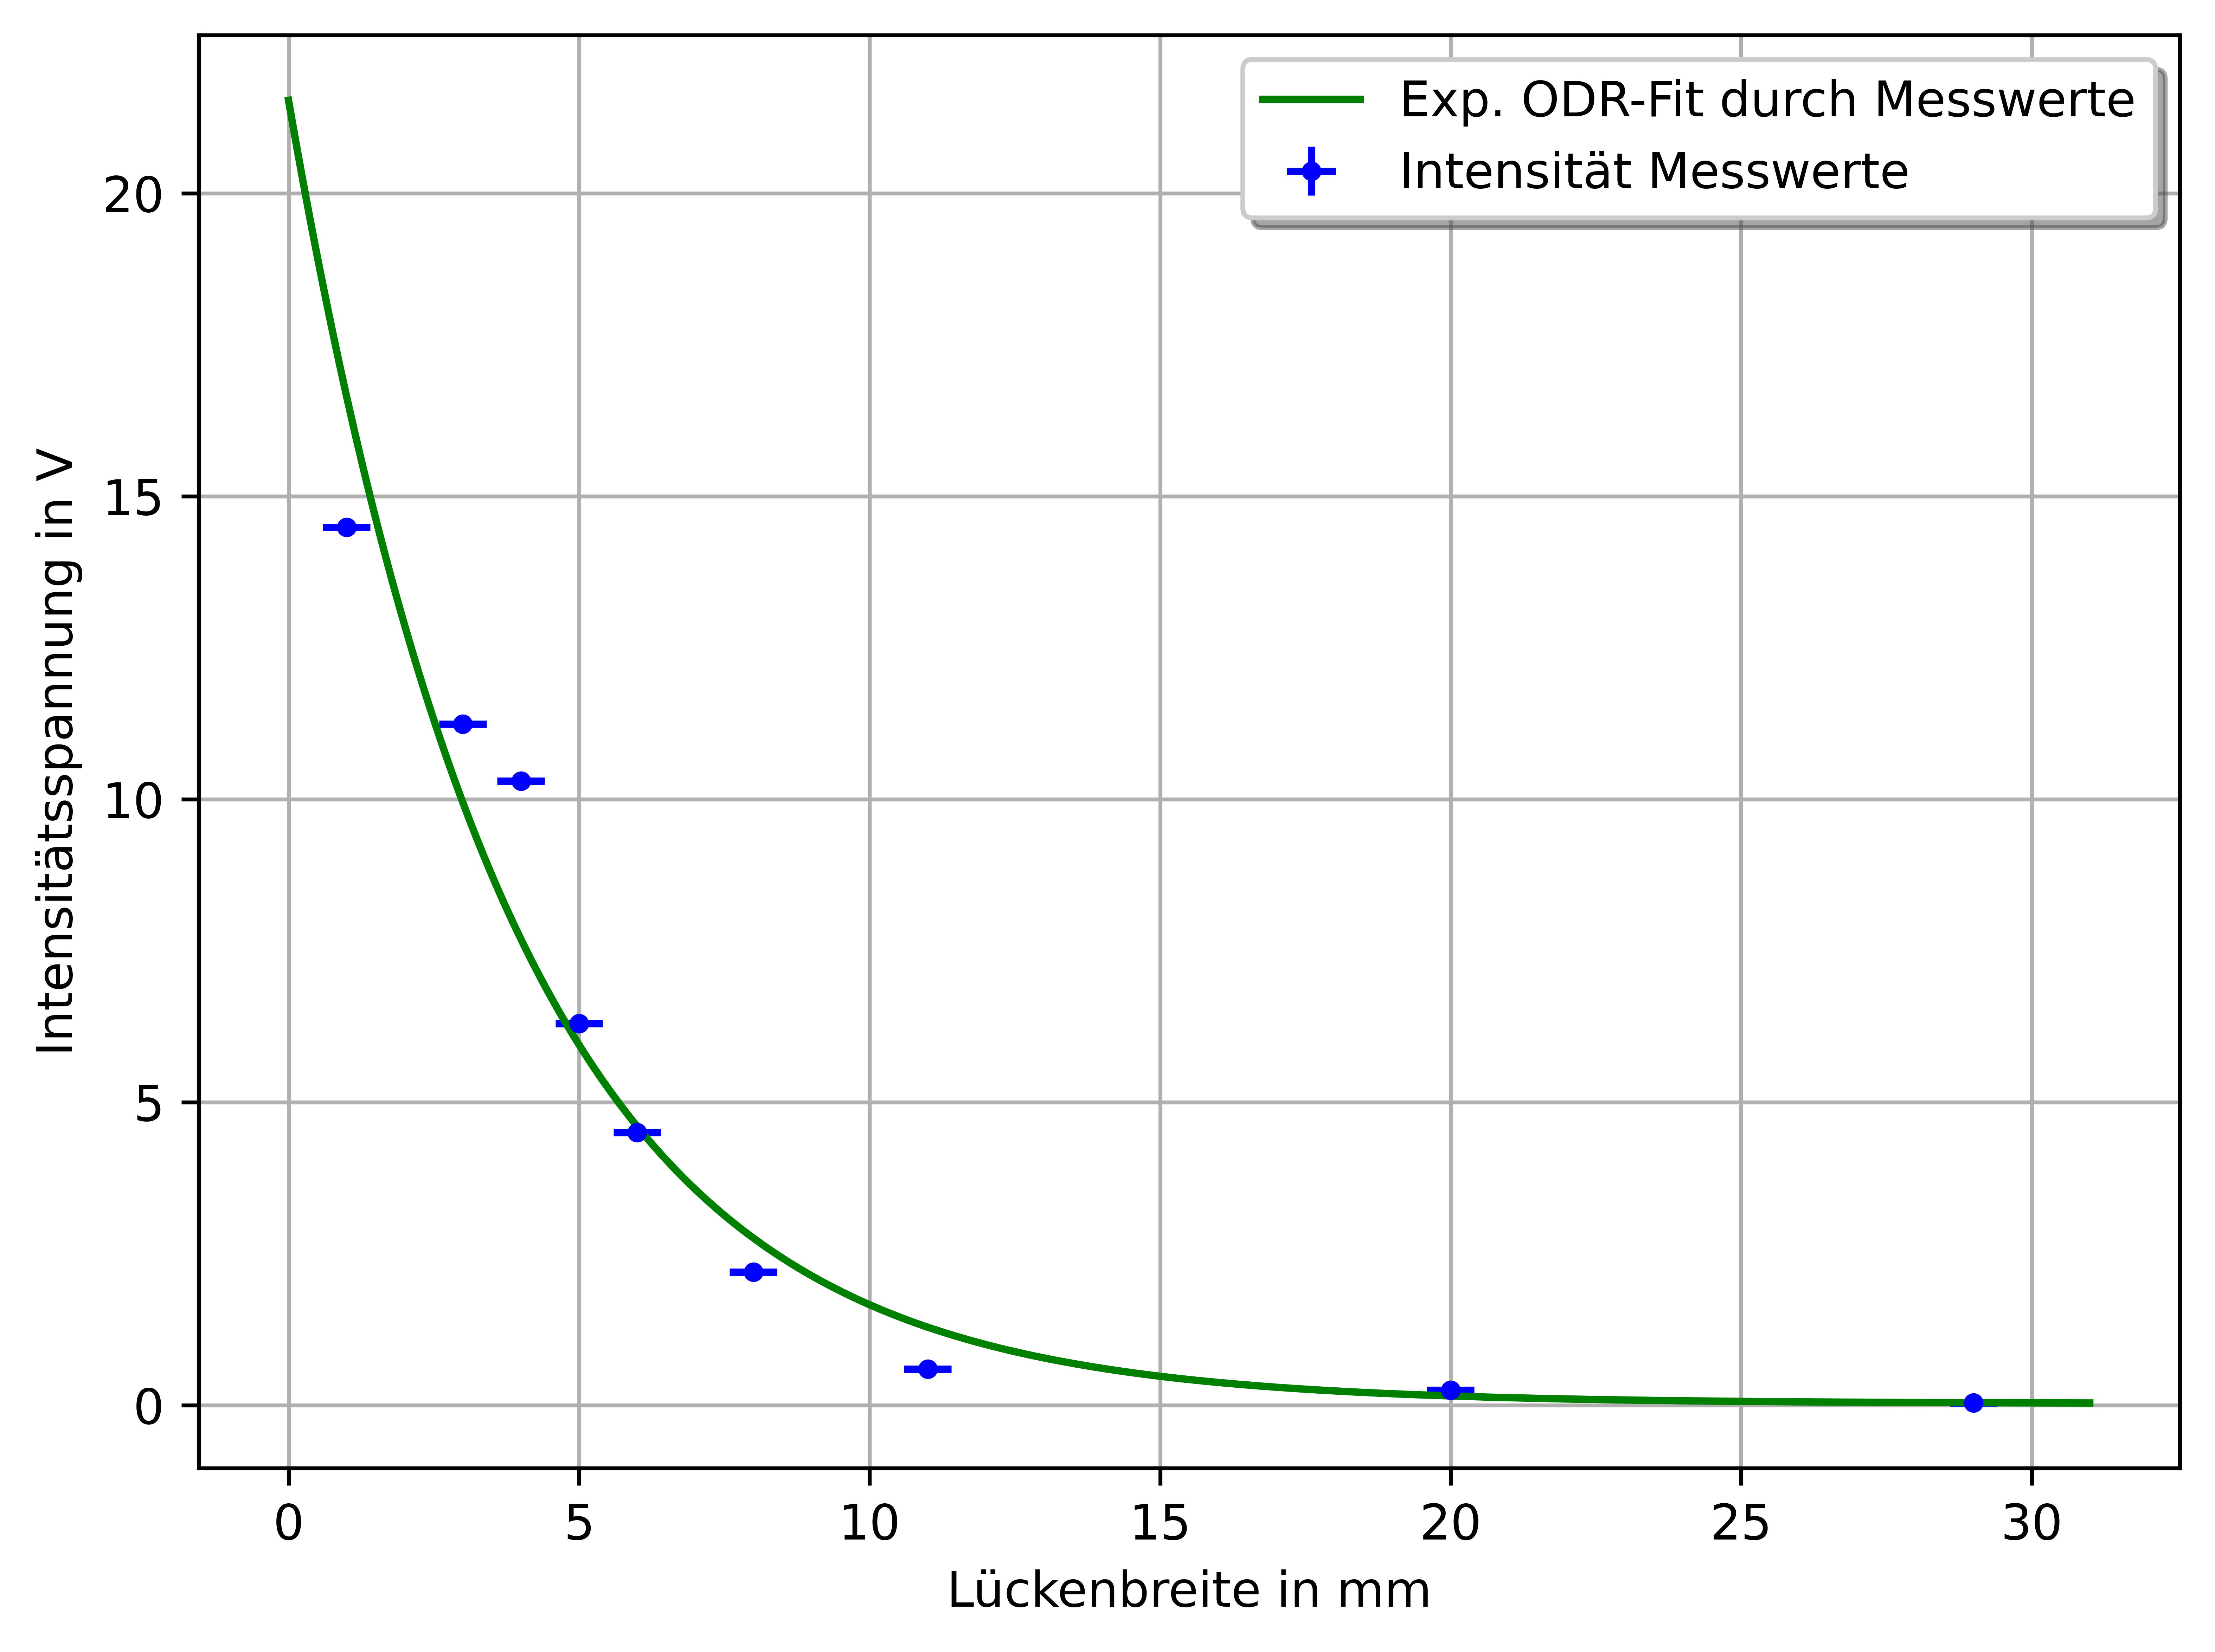

In [26]:
plt.figure(dpi=1000)

plt.errorbar(unp.nominal_values(breite_luecke*1000),unp.nominal_values(intensitaet_evaneszenz),
             xerr=unp.std_devs(breite_luecke*1000),yerr=unp.std_devs(intensitaet_evaneszenz),
             linestyle="", marker=".", color="blue",label="Intensität Messwerte")

x_int = np.linspace(0,31e-3,10000)
plt.plot(x_int*1000,exp_abfall(beta_evaneszenz,x_int),color="green",
         label="Exp. ODR-Fit durch Messwerte")

plt.grid()
plt.xlabel("Lückenbreite in mm") 
plt.ylabel("Intensitätsspannung in V")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig("plot_Evaneszenz.pdf")

# 7. Intensität bei Bragg-Reflektion messen, Gitterkonstante bestimmen

In [27]:
gitterkonstante_gemessen = ufloat(0.153,u_ablese_laenge)/4

#es ist ein messfehler aufgetreten: der würfel war in seiner halterung verdreht.
#Diese verdrehung wird hier abgeschätzt
verdrehung = unp.arctan(ufloat(7e-3,u_ablese_laenge)/ufloat(11.1e-2,u_ablese_laenge))
print(unp.degrees(verdrehung))
#verdrehung aufaddieren/abziehen/iwie verrechnen?
# -> am besten einen plot mit und einen ohne verdrehung machen
messwinkel = unp.radians(unp.uarray([15,20,25,30,35,40,45,50,55,60,65,70,75,80,90,100,110,120,130,140],
                        std_devs=u_ablese_winkel))

tetta = (np.pi - messwinkel)/2
tetta_krg = tetta+verdrehung
uarray_print_name(tetta)

intensitaet_bragg_messwerte = np.array([12e-3,35e-3,13e-3,4e-3,9e-3,30e-3,17e-3,9.5e-3,10e-3,26e-3,27e-3,30e-3,65e-3,29e-3,2e-3,6.5e-3,7.5e-3,5e-3,80e-3,90e-3])
u_intensitaet_bragg = u_messgeraet(x=intensitaet_bragg_messwerte,u_mess_rel=0.005, offset_u_mess=8e-4,
                                   u_ablese = dreieck(np.array([6,10,6,2,2,6,2,2,3,4,2,4,10,5,2,2,3,3,20,25])/1000)) 
intensitaet_bragg = unp.uarray(intensitaet_bragg_messwerte,
                               std_devs= u_intensitaet_bragg)

3.61+/-0.21
tetta :
1.4399(36)     1.3963(36)     1.3526(36)     1.3090(36)     1.2654(36)     
1.2217(36)     1.1781(36)     1.1345(36)     1.0908(36)     1.0472(36)     
1.0036(36)     0.9599(36)     0.9163(36)     0.8727(36)     0.7854(36)     
0.6981(36)     0.6109(36)     0.5236(36)     0.4363(36)     0.3491(36)     



plotten, auswerten, ka

In [28]:
resonanzwinkel=tetta_krg[12]
print(unp.degrees(resonanzwinkel))

erwartete_position_erstes_maximum =unp.degrees(unp.arcsin(wellenlaenge_avg/(2*gitterkonstante_gemessen)))
uprint_name(erwartete_position_erstes_maximum)
#bereich nicht auflösbar gewesen wegen strahldivergenz
#also ->
#Annahme: Maximum zweiter Ordnung
gitterkonstante_ermittelt = 2*wellenlaenge_avg/(2*unp.sin(resonanzwinkel))
uprint_name(gitterkonstante_ermittelt, unit="\cm",unit_factor=100)

lamBda,tetta = symbols('lamBda, tetta')
print(diff(lamBda/(2*sp.sin(tetta)),tetta))

56.11+/-0.29
gitterkonstante_ermittelt :   \SI{ 3.795(84) }{ \cm }
-lamBda*cos(tetta)/(2*sin(tetta)**2)


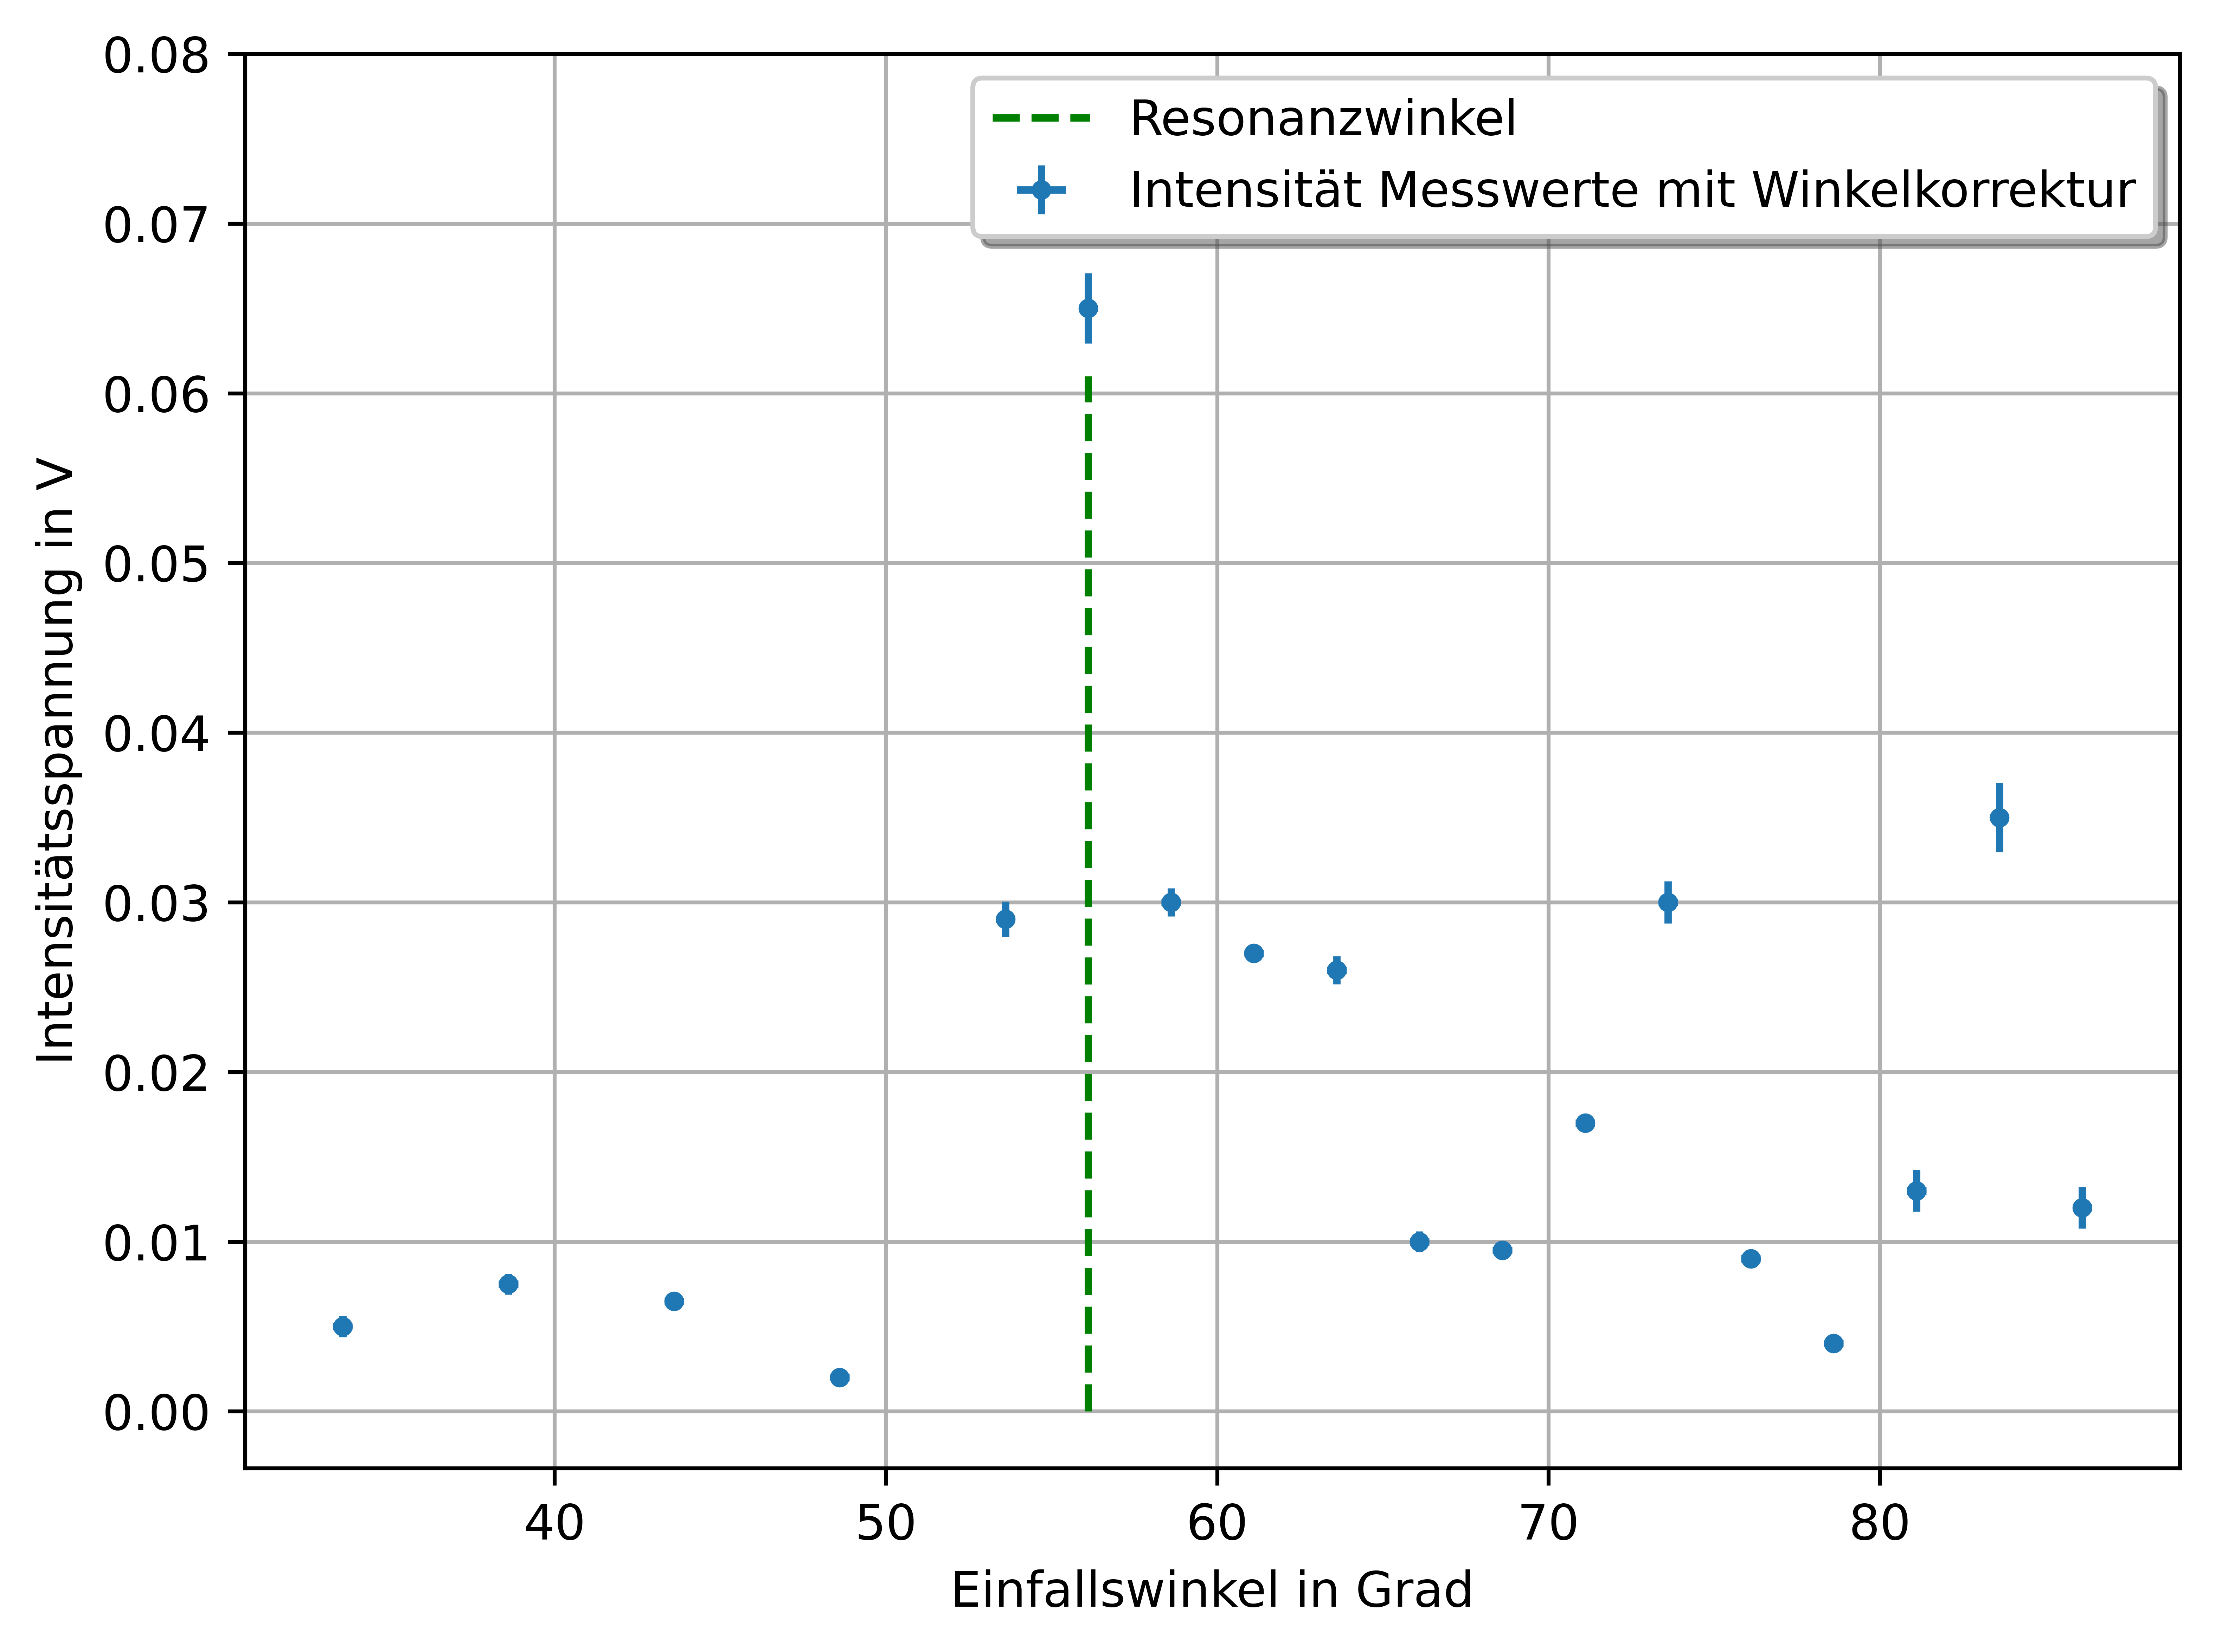

In [29]:
plt.figure(dpi=1000)

#plt.errorbar(unp.nominal_values(unp.degrees(tetta)[:18]),unp.nominal_values(intensitaet_bragg[:18]),
#             xerr=unp.std_devs(unp.degrees(tetta[:18])),yerr=unp.std_devs(intensitaet_bragg[:18]),
#             linestyle="",marker=".", label="Intensität Messwerte ohne Winkelkorrektur")
plt.vlines(unp.degrees(resonanzwinkel.n),ymin=0,ymax=0.061,
           linestyle="--",color='green',label="Resonanzwinkel")
plt.errorbar(unp.nominal_values(unp.degrees(tetta_krg)[:18]),unp.nominal_values(intensitaet_bragg[:18]),
             xerr=unp.std_devs(unp.degrees(tetta_krg[:18])),yerr=unp.std_devs(intensitaet_bragg[:18]),
             linestyle="",marker=".", label="Intensität Messwerte mit Winkelkorrektur")


plt.grid()
plt.ylim(top=0.08)
plt.xlabel("Einfallswinkel in Grad") 
plt.ylabel("Intensitätsspannung in V")
plt.legend(fancybox=True,shadow=True)
plt.tight_layout()
plt.savefig("plot_Bragg.pdf")

# Zusammenfassung der Ergebnisse

In [30]:
uprint_name(position_quellfleck, unit = "\cm", unit_factor=100)
uprint_name(strahldivergenz_aus_fit, unit = "\degrees")

position_quellfleck :   \SI{ 33(12) }{ \cm }
strahldivergenz_aus_fit :   \SI{ 11.0(1.4) }{ \degrees }


In [31]:
uprint_name(wellenlaenge_avg, unit = "\cm",unit_factor=100)

wellenlaenge_avg :   \SI{ 3.150(69) }{ \cm }


In [32]:
uprint_name(brechungsindex_pvc_avg)

brechungsindex_pvc_avg :   \SI{ 1.826(24) }{  }


In [36]:
fitparameter_exp_abfall=unp.uarray(beta_evaneszenz,beta_evaneszenz_err)
uarray_print_name(fitparameter_exp_abfall)

fitparameter_exp_abfall :
21.5(5.2)     258(29)     0.030(19)     


In [39]:
uprint_name(gitterkonstante_gemessen,unit="\cm", unit_factor=100)
uprint_name(gitterkonstante_ermittelt, unit="\cm",unit_factor=100)
rel_abweichung_gitterkonstante=rel_abweichung(messwert=gitterkonstante_ermittelt,theoriewert=gitterkonstante_gemessen)
uprint_name(rel_abweichung_gitterkonstante)


gitterkonstante_gemessen :   \SI{ 3.825(10) }{ \cm }
gitterkonstante_ermittelt :   \SI{ 3.795(84) }{ \cm }
rel_abweichung_gitterkonstante :   \SI{ -0.008(22) }{  }
24.32(57)
